# Convolutional neural networks

Olexander Chepurnoi, Yaroslava Lochman

In [145]:
_colab = True
if _colab:
  print('Using Google Colab')
  
  # !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive 
  from google.colab import auth 
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  # !pip install tensorboardcolab
  from tensorboardcolab import *
  
import pickle
import numpy as np
import keras
import matplotlib.pyplot as plt
print('Keras version using:', keras.__version__)

Using Google Colab
Keras version using: 2.2.4


In [0]:
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import TensorBoard
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import plot_model



## Loading images

In [0]:
if _colab:
  from keras.datasets import cifar10
  (train_images, train_labels), (cv_images, cv_labels) = cifar10.load_data()
else:
  train_images, train_labels = pickle.load(open('data/train_set_all.pkl', 'rb'))
  cv_images, cv_labels = pickle.load(open('data/test_set_all.pkl', 'rb'))

In [26]:
print(train_images.shape)
print(len(train_labels))

(50000, 32, 32, 3)
50000


In [27]:
print(cv_images.shape)
print(len(cv_labels))

(10000, 32, 32, 3)
10000


In [28]:
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [0]:
def show_image(np_array):
    %matplotlib inline
    plt.figure()
    plt.imshow(np_array)
    
def show_example(data_set, labels, example_index):
    show_image(data_set[example_index])
    print('Label: ', labels[example_index])

Label:  [6]


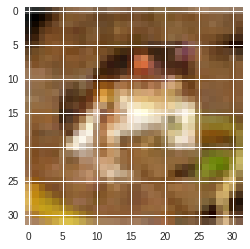

In [31]:
show_example(train_images, train_labels, example_index = 0)

Label:  [3]


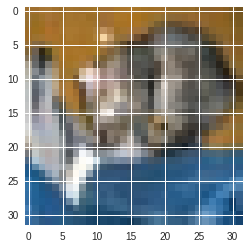

In [32]:
show_example(cv_images, cv_labels, example_index = 0)

## Preprocessing

In [0]:
num_classes = 10
train_y = np_utils.to_categorical(train_labels, num_classes)
cv_y = np_utils.to_categorical(cv_labels, num_classes)

train_images = train_images.astype('float32')
cv_images = cv_images.astype('float32')
train_images /= 255
cv_images /= 255

## Building AlexNet

In [0]:
def create_AlexNet(num_classes=10, k=1):
  model = Sequential()
  # 1
  model.add(Conv2D(48 * k, (11, 11), strides=(4,4), padding='same',
                   input_shape=train_images.shape[1:]))

  model.add(BatchNormalization(name="1_bn"))
  model.add(Activation('relu', name="1_relu"))
  model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same', name="1_maxpool"))
  
  # 2
  model.add(Conv2D(128 * k, (5, 5), strides=(1,1), padding='same', name="2_conv"))
  model.add(BatchNormalization(name="2_bn"))
  model.add(Activation('relu', name="2_relu"))
  model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same', name="2_maxpool"))
#   if dropout:
#     model.add(Dropout(0.5))

  # 3
  model.add(Conv2D(192 * k, (3, 3),  strides=(1,1), padding='same', name="3_conv"))
  model.add(Activation('relu', name="3_relu"))
    
  # 4
  model.add(Conv2D(192 * k, (3, 3),  strides=(1,1), padding='same', name="4_conv"))
  model.add(Activation('relu', name="4_relu"))
    
  # 5
  model.add(Conv2D(128 * k, (3, 3),  strides=(1,1), padding='same', name="5_conv"))
  model.add(BatchNormalization(name="5_bn"))
  model.add(Activation('relu', name="5_relu"))
  model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same', name="5_maxpool"))
#   if dropout:
#     model.add(Dropout(0.5))
  
  # 6
  model.add(Flatten(name="6_flatten"))
  model.add(Dropout(0.5, name="6_dropout"))
  model.add(Dense(2048 * k, name="6_fc"))
  model.add(BatchNormalization(name="6_bn"))
  model.add(Activation('relu', name="6_relu"))
    
  # 7
  model.add(Dropout(0.5, name="7_dropout"))
  model.add(Dense(2048 * k, name="7_fc"))
  model.add(BatchNormalization(name="7_bn"))
  model.add(Activation('relu', name="7_relu"))

  # 8
  model.add(Dense(num_classes, name="8_fc"))
  model.add(BatchNormalization(name="8_bn"))
  model.add(Activation('softmax', name="8_softmax"))
  return model

## Training AlexNet

In [138]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://ab1b3544.ngrok.io


In [146]:
model = create_AlexNet(num_classes)
model.summary()

sgd = keras.optimizers.SGD(lr=0.01, decay=5*1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                              patience=10, cooldown=1,
                                              min_lr=0.00001, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 8, 8, 48)          17472     
_________________________________________________________________
1_bn (BatchNormalization)    (None, 8, 8, 48)          192       
_________________________________________________________________
1_relu (Activation)          (None, 8, 8, 48)          0         
_________________________________________________________________
1_maxpool (MaxPooling2D)     (None, 4, 4, 48)          0         
_________________________________________________________________
2_conv (Conv2D)              (None, 4, 4, 128)         153728    
_________________________________________________________________
2_bn (BatchNormalization)    (None, 4, 4, 128)         512       
_________________________________________________________________
2_relu (Activation)          (None, 4, 4, 128)         0         
__________

In [140]:
epoch_start = 0
batch_size = 128
epochs = 90

model.fit(train_images, train_y,
      initial_epoch=epoch_start,
      batch_size=batch_size,
      epochs=epochs,
      shuffle=True,
      validation_data=(cv_images, cv_y),
      callbacks=[reduce_lr, TensorBoardColabCallback(tbc)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/90
50000/50000 [==============================] - 17s 330us/step - loss: 1.8845 - acc: 0.2605 - val_loss: 2.6133 - val_acc: 0.2209
Epoch 2/90
50000/50000 [==============================] - 13s 267us/step - loss: 1.5592 - acc: 0.4110 - val_loss: 1.9342 - val_acc: 0.3510
Epoch 3/90
50000/50000 [==============================] - 13s 266us/step - loss: 1.3378 - acc: 0.5117 - val_loss: 2.1123 - val_acc: 0.3516
Epoch 4/90
50000/50000 [==============================] - 13s 266us/step - loss: 1.2160 - acc: 0.5639 - val_loss: 1.6544 - val_acc: 0.4330
Epoch 5/90
50000/50000 [==============================] - 13s 265us/step - loss: 1.1181 - acc: 0.6056 - val_loss: 1.9566 - val_acc: 0.4015
Epoch 6/90
50000/50000 [==============================] - 13s 264us/step - loss: 1.0463 - acc: 0.6357 - val_loss: 1.4255 - val_acc: 0.5409
Epoch 7/90
50000/50000 [==============================] - 13s 266us/step - loss: 0.9789 - acc: 0.6610 - val_loss: 1.

In [150]:
scores = model.evaluate(cv_images, cv_y, verbose=1)
print('Test loss: {:.2f}'.format(scores[0]))
print('Test accuracy: {:.2f}%'.format(scores[1]*100))

10000/10000 [==============================] - 2s 242us/step
Test loss: 1.83
Test accuracy: 67.32%


In [142]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'alex-net_vanilla.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

if _colab:
  model_file = drive.CreateFile({'title' : model_name})
  model_file.SetContentFile(model_path)
  model_file.Upload()

Saved trained model at /content/saved_models/alex-net_vanilla.h5 


## Improving AlexNet

AlexNet was specifically created for a large-scale ImageNet dataset, that is much more complex than CIFAR-10, e.g. it has images of higher quality (224x224 in ImageNet vs. 32x32 in CIFAR), a huge (1000) number of various classes with its hierarchy (vs. simple 10 in CIFAR), 1.2 million images in total vs. 60 thousand in CIFAR. The architecture is as complex as it should be for such dataset, but for ours, it over-complicated and thus is easy to overfit, as we can see from the classification results above. So to achieve a good generalization, we need to revisit the model and optimization configurations. Also, we suggest using data augmentation to enlarge and diversify training data.

In [0]:
def create_modified_AlexNet():
  model = Sequential()
  # 1
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=train_images.shape[1:]))
  model.add(Activation('relu'))
  
  # 2
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # 3
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  
  # 4
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # 5
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # 6
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
  # 7
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
  # 8
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  return model

In [0]:
tbc = TensorBoardColab()

In [0]:
model = create_modified_AlexNet()
# model.summary()


# rmsprop = keras.optimizers.rmsprop(lr=0.01, decay=1e-6)
sgd = keras.optimizers.SGD(lr=0.01, decay=5*1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                              patience=10, cooldown=1,
                                              min_lr=0.00001, verbose=1)

In [0]:
epoch_start = 0
batch_size = 128
epochs = 90

model.fit(train_images, train_y,
      initial_epoch=epoch_start,
      batch_size=batch_size,
      epochs=epochs,
      shuffle=True,
      validation_data=(cv_images, cv_y),
      callbacks=[reduce_lr, TensorBoardColabCallback(tbc)])

In [53]:
# Data augmentation

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)

datagen.fit(train_images)

epoch_start = 0
batch_size = 32
epochs = 25

model.fit_generator(datagen.flow(train_images, train_y,
                                 batch_size=batch_size),
                    initial_epoch=epoch_start,
                    epochs=epochs,
                    validation_data=(cv_images, cv_y),
                    workers=4, 
                    steps_per_epoch=1500,  
                    callbacks=[TensorBoardColabCallback(tbc)])

Epoch 1/25
1500/1500 [==============================] - 46s 31ms/step - loss: 1.8489 - acc: 0.3182 - val_loss: 1.6276 - val_acc: 0.4064
Epoch 2/25
1500/1500 [==============================] - 45s 30ms/step - loss: 1.5826 - acc: 0.4197 - val_loss: 1.3880 - val_acc: 0.4900
Epoch 3/25
1500/1500 [==============================] - 45s 30ms/step - loss: 1.4672 - acc: 0.4665 - val_loss: 1.2890 - val_acc: 0.5320
Epoch 4/25
1500/1500 [==============================] - 45s 30ms/step - loss: 1.3932 - acc: 0.4953 - val_loss: 1.2302 - val_acc: 0.5623
Epoch 5/25
1500/1500 [==============================] - 45s 30ms/step - loss: 1.3244 - acc: 0.5245 - val_loss: 1.1358 - val_acc: 0.6003
Epoch 6/25
1500/1500 [==============================] - 45s 30ms/step - loss: 1.2628 - acc: 0.5475 - val_loss: 1.1348 - val_acc: 0.5959
Epoch 7/25
1500/1500 [==============================] - 45s 30ms/step - loss: 1.2142 - acc: 0.5667 - val_loss: 1.0937 - val_acc: 0.6157
Epoch 8/25
1500/1500 [==========================

Use training set for training the network to recognize objects. You might want to use RMSProp optimizer to speed up the training.

Convolutional networks require a lot of computing power for training. Typical setup for training CNN is to use GPU, however, in this problem you are not required to do so. CPU will be fine as well.

If you are using CPU for this subproblem, training process might be slow. You can stop it manually as soon as you get meaningful results.

Report the results on the training and cross-validation sets. The report should contain the training logs.

In [0]:
# _train = True
# epoch_start = 19
# if _train:
#     my_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     my_model.fit(train_images, train_y,
#                  initial_epoch=epoch_start,
#                  epochs=92,
#                  batch_size=256,
#                  shuffle=True,
#                  validation_data=(cv_images, cv_y),
#                  callbacks=[TensorBoardColabCallback(tbc)])